In [2]:
import sys
sys.path.append("../CNNFiltering/CNNAnalyze/test/")

In [3]:
import urllib.request

In [4]:
import os

In [5]:
import pandas as pd

In [6]:
import numpy as np

In [38]:
from time import time

In [7]:
from dataset import *

In [8]:
import matplotlib.pyplot as plt
from matplotlib import colors

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

In [17]:
!curl http://opendata-dev.web.cern.ch/record/12320/files/TTbar_13TeV_PU50_PixelSeeds_pixelTracksDoublets_h5_file_index.txt -o file_index.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 21338  100 21338    0     0  45303      0 --:--:-- --:--:-- --:--:-- 45303


In [18]:
file_list = !(cat file_index.txt)

In [20]:
for f in file_list:
    print(f)

http://opendata.cern.ch/eos/opendata/cms/datascience/CNNPixelSeedsProducerTool/TTbar_13TeV_PU50_PixelSeeds/TTbar_PU50_pixelTracksDoublets_0_final.h5
http://opendata.cern.ch/eos/opendata/cms/datascience/CNNPixelSeedsProducerTool/TTbar_13TeV_PU50_PixelSeeds/TTbar_PU50_pixelTracksDoublets_100_final.h5
http://opendata.cern.ch/eos/opendata/cms/datascience/CNNPixelSeedsProducerTool/TTbar_13TeV_PU50_PixelSeeds/TTbar_PU50_pixelTracksDoublets_101_final.h5
http://opendata.cern.ch/eos/opendata/cms/datascience/CNNPixelSeedsProducerTool/TTbar_13TeV_PU50_PixelSeeds/TTbar_PU50_pixelTracksDoublets_102_final.h5
http://opendata.cern.ch/eos/opendata/cms/datascience/CNNPixelSeedsProducerTool/TTbar_13TeV_PU50_PixelSeeds/TTbar_PU50_pixelTracksDoublets_103_final.h5
http://opendata.cern.ch/eos/opendata/cms/datascience/CNNPixelSeedsProducerTool/TTbar_13TeV_PU50_PixelSeeds/TTbar_PU50_pixelTracksDoublets_104_final.h5
http://opendata.cern.ch/eos/opendata/cms/datascience/CNNPixelSeedsProducerTool/TTbar_13TeV_PU50_

In [11]:
remote_data = "./"
data_files = [remote_data + "/" + f for f in os.listdir(remote_data) if "Doublets" in f and f.endswith("h5")]
print(data_files)

['.//TTbar_PU50_pixelTracksDoublets_0_final.h5']


In [12]:
data = pd.read_hdf(data_files[0])

In [26]:
true = (data["label"]==1.0)
fake = (data["label"]==-1.0)

In [24]:
print("Number of doublets: %d"%len(data))

Number of doublets: 5381062


In [14]:
data.head()

,run,evt,lumi,PU,bSX,bSY,bSZ,inX,inY,inZ,...,outTpNTrackerHits,outTpNTrackerLayers,outTpPhi,outTpEta,outTpRapidity,outTpVX,outTpVY,outTpVZ,outTpDXY,outTpDZ
0,1,19677,32,56,0.01078,0.041893,0.024875,-2.77830,0.180103,6.905110,...,9,6,-2.78931,-0.546989,-0.363328,-0.864592,0.337032,0.892199,-0.614653,1.29172
1,1,19677,32,56,0.01078,0.041893,0.024875,-2.77916,0.175317,-1.999620,...,9,6,-2.78931,-0.546989,-0.363328,-0.864592,0.337032,0.892199,-0.614653,1.29172
2,1,19677,32,56,0.01078,0.041893,0.024875,-2.78293,0.160660,2.749980,...,9,6,-2.78931,-0.546989,-0.363328,-0.864592,0.337032,0.892199,-0.614653,1.29172
3,1,19677,32,56,0.01078,0.041893,0.024875,-2.78288,0.160651,-4.482520,...,9,6,-2.78931,-0.546989,-0.363328,-0.864592,0.337032,0.892199,-0.614653,1.29172
4,1,19677,32,56,0.01078,0.041893,0.024875,-2.78663,0.146041,0.781881,...,9,6,-2.78931,-0.546989,-0.363328,-0.864592,0.337032,0.892199,-0.614653,1.29172


Balancing true and fake seeds so that $N_{true}/N_{fake}=1$

In [27]:
sig = data[true]

In [29]:
bkg = data[fake].sample(n=len(sig))

In [30]:
data = pd.concat([sig,bkg]).sample(frac=1.0)

In [32]:
print("New number of doublets: %d"%len(data))

New number of doublets: 277224


## BDT Testing

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [31]:
X = data[featureLabs].values
Y = data["label"] == 1.0

In [105]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

In [52]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                         algorithm="SAMME",
                         n_estimators=1000)

In [53]:
print ("BDT Training")
t = time()
bdt.fit(X_train,Y_train)

BDT Training


AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=1000, random_state=None)

In [54]:
twoclass_output = bdt.decision_function(X_test)
bdt_acc = bdt.score(X_test,Y_test)
print ("BDT accuracy = %.3f"%(bdt_acc))

BDT accuracy = 0.815


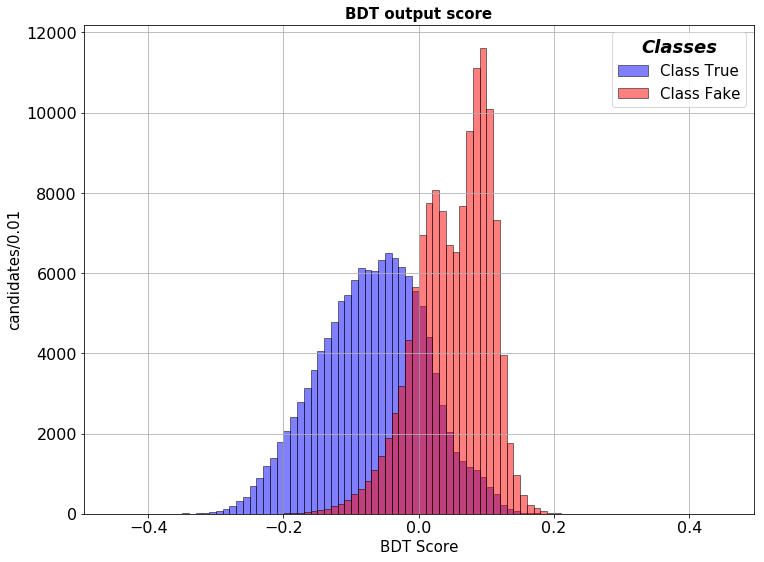

In [55]:
plot_colors = "br"
plot_step = 0.02
class_names = ["True", "Fake"]

plot_range = (-0.45,0.45)#(twoclass_output.min(), twoclass_output.max())
plt.figure(figsize=(12,9))


for i, n, c in zip([0.0,1.0], class_names, plot_colors):
    plt.hist(twoclass_output[ Y_test == i],
             bins=90,
             range=plot_range,
             facecolor=c,
             label='Class %s' % n,
             alpha=.5,
             edgecolor='k')
    
plt.grid()
ax = plt.gca()
#ax.margins(x=0,y=0,tight=False)
legend = plt.legend(title="Classes",fontsize=15)

plt.setp(legend.get_title(),fontsize=18,fontweight="bold",fontstyle="italic")
plt.title("BDT output score",fontsize=15,fontweight="bold")
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)

plt.xlabel("BDT Score",fontsize=15)
plt.ylabel("candidates/0.01",fontsize=15)

test_roc = roc_auc_score(Y_test, twoclass_output)
fp, tp, _ = roc_curve(Y_test,twoclass_output)


In [62]:
i= 1 + i
effFive      = fp[np.where(tp > 0.95)[0][0]]
effTen       = fp[np.where(tp > 0.90)[0][0]]
effTwenty    = fp[np.where(tp > 0.8)[0][0]]
effHalf      = fp[np.where(tp > 0.5)[0][0]]
effSeventy   = fp[np.where(tp > 0.25)[0][0]]
effNinenty   = fp[np.where(tp > 0.1)[0][0]]
effNineFive  = fp[np.where(tp > 0.05)[0][0]]
effNineEight = fp[np.where(tp > 0.02)[0][0]]
effNineNine  = fp[np.where(tp > 0.01)[0][0]]

rejFive      = tp[np.where(fp > 0.95)[0][0]]
rejTen       = tp[np.where(fp > 0.90)[0][0]]
rejTwenty    = tp[np.where(fp > 0.8)[0][0]]
rejHalf      = tp[np.where(fp > 0.5)[0][0]]
rejSeventy   = tp[np.where(fp > 0.25)[0][0]]
rejNinenty   = tp[np.where(fp > 0.1)[0][0]]
rejNineFive  = tp[np.where(fp > 0.05)[0][0]]
rejNineEight = tp[np.where(fp > 0.02)[0][0]]
rejNineNine  = tp[np.where(tp > 0.01)[0][0]]
#thrNinenty   = tr[np.where(fp > 0.1)[0][0]]
#thrNineFive  = tr[np.where(fp > 0.05)[0][0]]

print ("==========================================")
print ("Fake Rejection @ 0.50 Efficiency : %.2f " % (rejHalf))
print ("Fake Rejection @ 0.75 Efficiency : %.2f " % (rejSeventy))
print ("Fake Rejection @ 0.90 Efficiency : %.2f " % (rejNinenty))
print ("Fake Rejection @ 0.95 Efficiency : %.2f " % (rejNineEight))
print ("Fake Rejection @ 0.98 Efficiency : %.2f " % (rejNineFive))
print ("Fake Rejection @ 0.99 Efficiency : %.2f " % (rejNineNine))
print ("==========================================")

print ("Efficiency @ 0.50 Fake Rejection  : %.2f " % (effHalf))
print ("Efficiency @ 0.75 Fake Rejection  : %.2f " % (effSeventy))
print ("Efficiency @ 0.90 Fake Rejection  : %.2f " % (effNinenty))
print ("Efficiency @ 0.95 Fake Rejection  : %.2f " % (effNineEight))
print ("Efficiency @ 0.98 Fake Rejection  : %.2f " % (effNineFive))
print ("Efficiency @ 0.99 Fake Rejection  : %.2f " % (effNineNine))
print ("==========================================")

Fake Rejection @ 0.50 Efficiency : 0.97 
Fake Rejection @ 0.75 Efficiency : 0.88 
Fake Rejection @ 0.90 Efficiency : 0.67 
Fake Rejection @ 0.95 Efficiency : 0.28 
Fake Rejection @ 0.98 Efficiency : 0.51 
Fake Rejection @ 0.99 Efficiency : 0.01 
Efficiency @ 0.50 Fake Rejection  : 0.05 
Efficiency @ 0.75 Fake Rejection  : 0.02 
Efficiency @ 0.90 Fake Rejection  : 0.01 
Efficiency @ 0.95 Fake Rejection  : 0.00 
Efficiency @ 0.98 Fake Rejection  : 0.00 
Efficiency @ 0.99 Fake Rejection  : 0.00 


## Simple DNN Testing

In [66]:
import keras

Using TensorFlow backend.


In [71]:
from keras.layers import Input, Flatten, Dense
from keras.layers import concatenate, Dropout, BatchNormalization
from keras.models import Model
from keras import optimizers
from keras.constraints import max_norm

In [77]:
from keras.utils import to_categorical

In [78]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [87]:
features   = Input(shape=(len(featureLabs),), name='hit_input')
b_norm = BatchNormalization()(features)
dense = Dense(64, activation='relu', kernel_constraint=max_norm(0.1), name='dense_1')(features)
dense = Dense(64, activation='relu', kernel_constraint=max_norm(0.1), name='dense_2')(dense)
drop = Dropout(0.5)(dense)
dense = Dense(64, activation='relu', kernel_constraint=max_norm(0.1), name='dense_3')(drop)
dense = Dense(64, activation='relu', kernel_constraint=max_norm(0.1), name='dense_4')(dense)
b_norm = BatchNormalization()(dense)
pred = Dense(2, activation='relu', kernel_constraint=max_norm(0.1), name='output')(b_norm)

model = Model(inputs=features, outputs=pred)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    

In [101]:
callbacks = [EarlyStopping(monitor='val_loss', patience=50),
            ModelCheckpoint("best_model.h5",save_best_only="True")]

In [106]:
Y_train_onehot = to_categorical(Y_train)

In [103]:
X_train = X_train/np.max(X_train,axis=0)

In [ ]:
history = model.fit(X_train, Y_train_onehot, batch_size = 1024 , epochs=100, shuffle=True,validation_split=0.15, callbacks=callbacks, verbose=1)